<h1 align=center> Sentiment Analysis</h1>

### Importing Libraries

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline 

import xgboost as xgb
from lime import lime_text
from lime.lime_text import LimeTextExplainer

### Loading Data

In [2]:
with open('merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.reset_index(drop=True, inplace=True)
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


### Exploring Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [5]:
print(f"number of duplicate: {data.duplicated().sum()} tweets")
data.drop_duplicates(inplace=True)

number of duplicate: 686 tweets


joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: emotions, dtype: int64


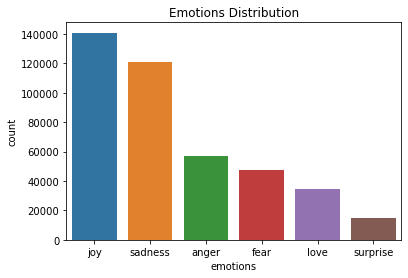

In [6]:
v = data['emotions'].value_counts()
classes = np.unique(data['emotions'])
sns.barplot(x=v.index, y=v.values)
plt.xlabel('emotions')
plt.ylabel('count')
plt.title('Emotions Distribution')
print(f"{v}")

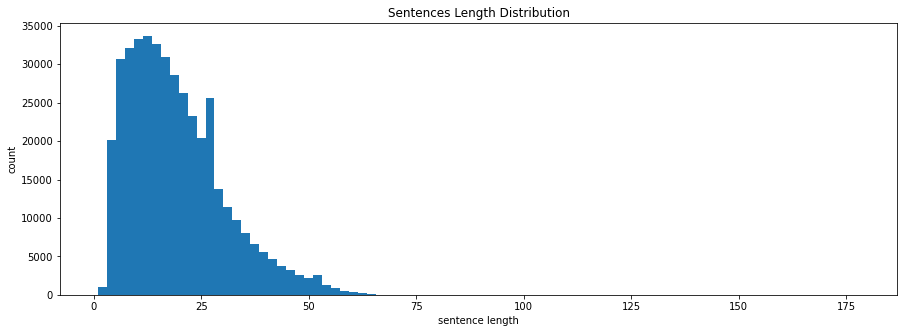

In [7]:
lengths = [len(x.split()) for x in data['text']]
plt.figure(figsize=(15,5))
plt.hist(lengths, bins=len(set(lengths)))
plt.xlabel('sentence length')
plt.ylabel('count')
plt.title('Sentences Length Distribution');

### Comparing Emotions Features

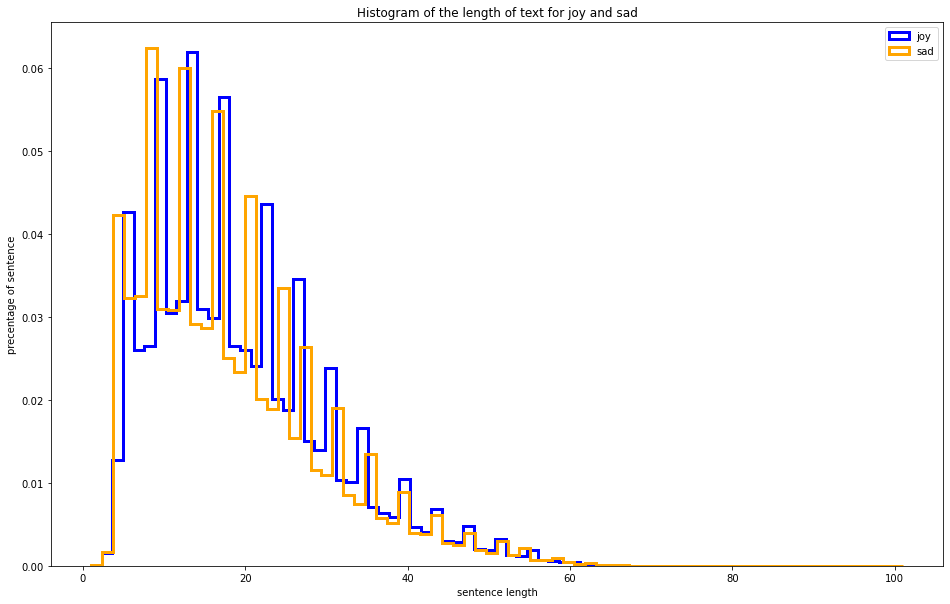

In [8]:
lens = []

joy_df = data.query('emotions == "joy"')
joy_len = [len(x.split()) for x in joy_df['text']]
lens.append(np.array(joy_len))

sad_df = data.query('emotions == "sadness"')
sad_len = [len(x.split()) for x in sad_df['text']]
lens.append(np.array(sad_len))

plt.figure(figsize=(16, 10))
plt.hist(joy_len, density=True, histtype = "step", bins=len(set(joy_len)), color='blue', label='joy', linewidth=3)
plt.hist(sad_len, density=True, histtype = "step", bins=len(set(sad_len)), color='orange', label='sad', linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for joy and sad')
plt.show()

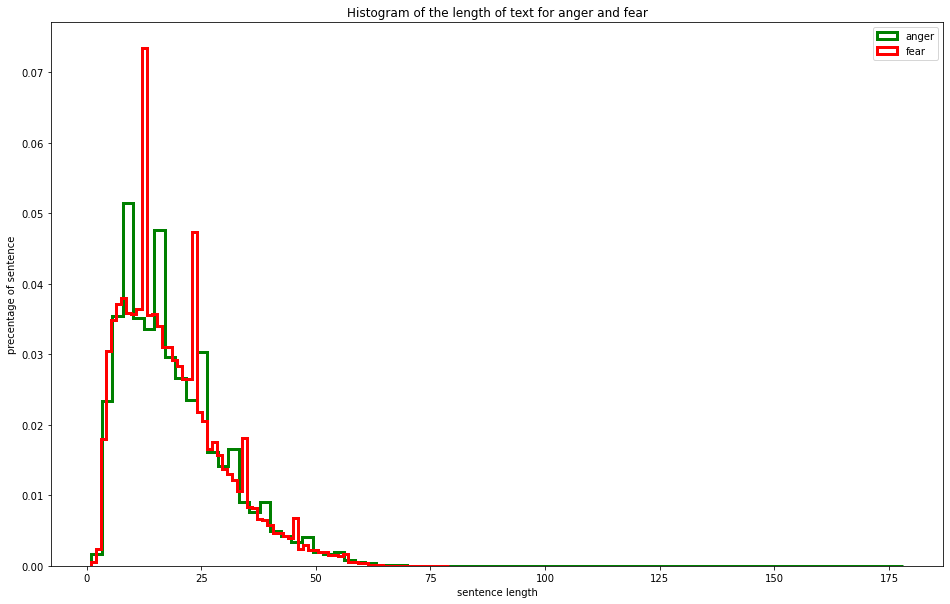

In [9]:
anger_df = data.query('emotions == "anger"')
anger_len = [len(x.split()) for x in anger_df['text']]
lens.append(np.array(anger_len))

fear_df = data.query('emotions == "fear"')
fear_len = [len(x.split()) for x in fear_df['text']]
lens.append(np.array(fear_len))

plt.figure(figsize=(16, 10))
plt.hist(anger_len, density=True, histtype = "step", bins=len(set(anger_len)), color='green', label='anger', linewidth=3)
plt.hist(fear_len, density=True, histtype = "step", bins=len(set(fear_len)), color='r', label='fear', linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for anger and fear')
plt.show()

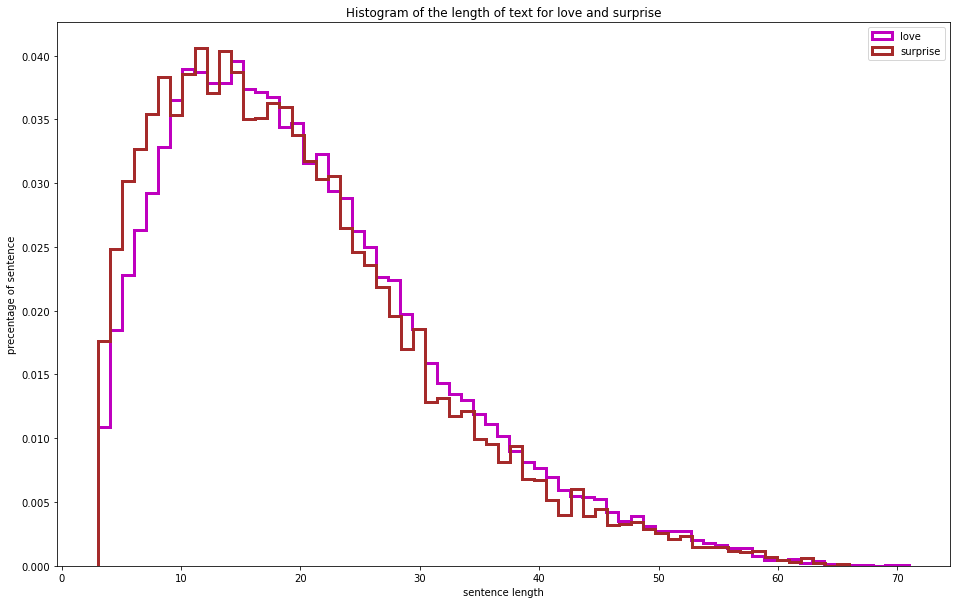

In [10]:
love_df = data.query('emotions == "love"')
love_len = [len(x.split()) for x in love_df['text']]
lens.append(np.array(love_len))

surprise_df = data.query('emotions == "surprise"')
surprise_len = [len(x.split()) for x in surprise_df['text']]
lens.append(np.array(surprise_len))

plt.figure(figsize=(16, 10))
plt.hist(love_len, density=True, histtype = "step", bins=len(set(love_len)), color='m', label='love', linewidth=3)
plt.hist(surprise_len, density=True, histtype = "step", bins=len(set(surprise_len)), color='brown', label='surprise',
         linewidth=3)
plt.legend()
plt.xlabel('sentence length')
plt.ylabel('precentage of sentence')
plt.title('Histogram of the length of text for love and surprise')
plt.show()

the average length of a sentence for each class

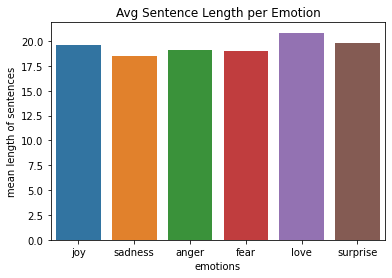

In [11]:
lens = np.array(lens, dtype='object')
lens_mean = [x.mean() for x in lens] 
sns.barplot(x=v.index, y=lens_mean)
plt.xlabel('emotions')
plt.ylabel('mean length of sentences')
plt.title('Avg Sentence Length per Emotion');

### Helper Functions

In [12]:
# function to plot the confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return cm

In [13]:
# from class labels to indices and from indices to class labels
c_to_i = dict((v, i) for i, v in enumerate(classes))
i_to_c = dict((i, v) for i, v in enumerate(classes))
to_indices = lambda labels: np.array([c_to_i.get(x) for x in labels])
to_classes = lambda idx: np.array([i_to_c.get(x) for x in idx])

In [14]:
def predict_example(s, pipline):
    s_ = np.expand_dims(s, (-1))
    p = pipline.predict(s_)[0]
    print(f"{s}\nPredicted as: {p} text")

In [15]:
# import subprocess
# print((subprocess.check_output("cpu", shell=True, stderr=subprocess.STDOUT).strip()).decode())

# Dataset As Is (Imbalanced)

## XGboost Approach

Spiliting Data

In [16]:
text = data['text'].values
y = data['emotions'].values

# data_dmatrix = xgb.DMatrix(data=text, label=y)

X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.2)

Preprocessing Text Format

In [17]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

Training XGBoost Classifier

In [18]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train_trans, y_train)

Wall time: 54.2 s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Evaluating The Model

In [19]:
preds = clf.predict(X_test_trans)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.95      0.68      0.79     11388
        fear       0.94      0.66      0.77      9701
         joy       0.67      0.97      0.79     28154
        love       0.91      0.61      0.73      6839
     sadness       0.96      0.79      0.87     24232
    surprise       0.78      0.71      0.75      2911

    accuracy                           0.80     83225
   macro avg       0.87      0.74      0.78     83225
weighted avg       0.85      0.80      0.81     83225



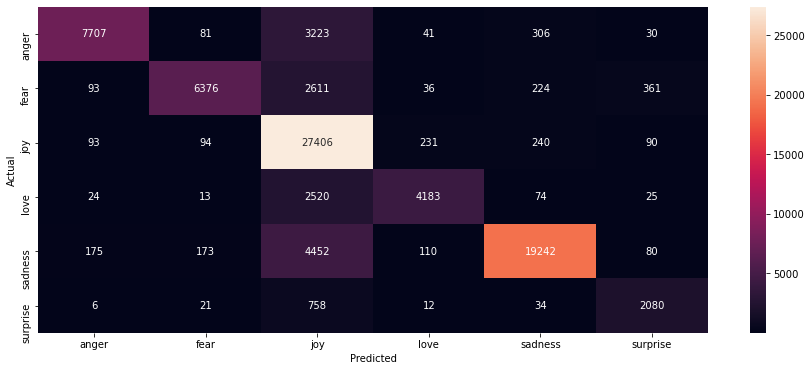

In [20]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

### Model Wrong Predictions

In [21]:
x = (preds != y_test)
wrong_pred, wrong_true, wrong_text = preds[x], y_test[x], X_test[x]
correct_pred, correct_true, correct_text = preds[~x], y_test[~x], X_test[~x]

wrong_df = pd.DataFrame(data={'text':wrong_text, 'prediction':wrong_pred, 'label':wrong_true})
pd.options.display.max_colwidth = 500
wrong_df.head(8)

,text,prediction,label
0,i feel like i need to share and also it means some point soon i will want and have to take some compassionate leave i feel better for discussing it and making them aware of why i will be up and down,joy,love
1,i describe his gentle nature and how being in his presence made me feel more tranquil,love,joy
2,i had made an appointment with three friends we had to go out together when i arrived at the place,joy,anger
3,i just wish i didnt feel like my roommates hated me half the time,joy,anger
4,im feeling sarcastic this morning,joy,anger
5,i fell a little dizzy maybe because i did not have my breakfast after have a short rest i went to the little hill it make people feel a litttle fear i am a timid girl but i like adventuring i like see horrible movies,sadness,fear
6,i feel so strongly about the main characters introducing a supporting character is always hot and cold with me,love,joy
7,i would have thought if i was paying attention to her but i had just finished at the urinal feeling distressed instead of relieved for doing so,joy,fear


### Explaining Instances Using LIME Explainer

In [22]:
c = make_pipeline(vectorizer, clf)
exp = LimeTextExplainer(class_names= classes)

In [23]:
idx = 1
explained = exp.explain_instance(wrong_df.iloc[idx]['text'], c.predict_proba,num_features=10, top_labels=2)
explained.show_in_notebook(text=wrong_df.iloc[idx]['text'])

In [24]:
s1 = np.array("This historical moment marked the first time a black woman has won \
the coveted Best Actress award, and is reflected in the minute or so where \
Halle Berry composes herself. She does so wonderfully, and utters the now-famous words:\
“this moment is so much bigger than me.”")

s2 = np.array("Sometimes we feel like crying “in a good way,” which is exactly what Carl \
Sagan’s speech about the future of humanity could look like does for us.")

s3 = np.array("There are so many examples of beautiful, personal TED talks. But there is no \
better example of this than Sherwin Nuland’s vivid talk about his struggle with depression and \
his experience with second chances.")

s4 = np.array("I wanted to kill someone and I wanted to die and I wanted to run as far and as fast \
as I could because she was never coming back. She had fallen off the face of the earth and she was never coming back.")

# print(f"{predict_example(s1)}{predict_example(s2)}")
predict_example(s1, c)
print('\n')
predict_example(s2, c)
print('\n')
predict_example(s3, c)
print('\n')
predict_example(s4, c)
print("This text meant to be: as a sad quote")

This historical moment marked the first time a black woman has won the coveted Best Actress award, and is reflected in the minute or so where Halle Berry composes herself. She does so wonderfully, and utters the now-famous words:“this moment is so much bigger than me.”
Predicted as: joy text


Sometimes we feel like crying “in a good way,” which is exactly what Carl Sagan’s speech about the future of humanity could look like does for us.
Predicted as: joy text


There are so many examples of beautiful, personal TED talks. But there is no better example of this than Sherwin Nuland’s vivid talk about his struggle with depression and his experience with second chances.
Predicted as: joy text


I wanted to kill someone and I wanted to die and I wanted to run as far and as fast as I could because she was never coming back. She had fallen off the face of the earth and she was never coming back.
Predicted as: joy text
This text meant to be: as a sad quote


in the last text example the model predicted it as an joy text but its actually a sad text/quote so I'm going to use lime explainer to see what's going on inside the model prediction.

In [25]:
explained = exp.explain_instance(str(s4), c.predict_proba,num_features=7, top_labels=2)
explained.show_in_notebook(text=str(s4))

the model is in favor towards joy more than sadness.

In [26]:
tweet = "hello nice to meet you"
predict_example(tweet, c)

hello nice to meet you
Predicted as: joy text


# Dealing With an Imbalnced Dataset

## 1- Under Sampling

In [27]:
min_class_count = min(data['emotions'].value_counts())

grouped = data.groupby('emotions')['text'].apply(lambda x: x.sample(min_class_count))
data_under = grouped.reset_index()
data_under.drop(['level_1'], axis=1, inplace=True)
data_under = data_under.sample(frac=1)
data_under.reset_index(inplace=True, drop=True)
data_under.emotions.value_counts()

love        14959
fear        14959
joy         14959
surprise    14959
anger       14959
sadness     14959
Name: emotions, dtype: int64

### XGBoost Approach

Spliting Data

In [28]:
text = data_under['text'].values
y = data_under['emotions'].values

X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.1)

Preprocessing Text Foramt

In [29]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

Training the Model

In [30]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train_trans, y_train)

Wall time: 14.2 s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Evaluating the Model

In [31]:
preds = clf.predict(X_test_trans)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.93      0.85      0.89      1477
        fear       0.91      0.84      0.87      1498
         joy       0.77      0.87      0.82      1506
        love       0.89      0.94      0.91      1493
     sadness       0.96      0.82      0.88      1493
    surprise       0.88      0.99      0.93      1509

    accuracy                           0.88      8976
   macro avg       0.89      0.88      0.88      8976
weighted avg       0.89      0.88      0.88      8976



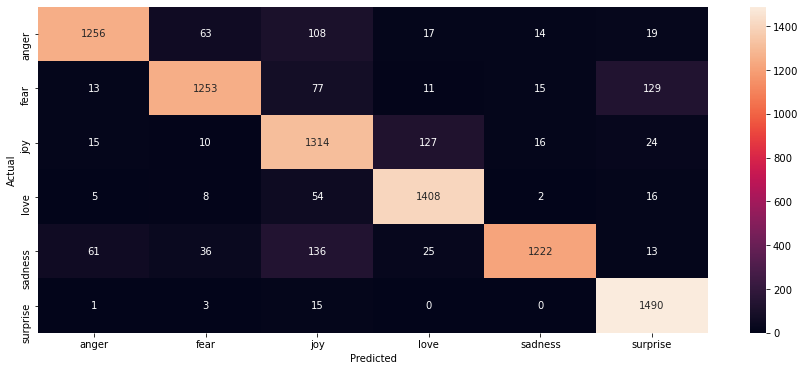

In [32]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

## 2- Under Sampling: TomekLinks

### XGboost Approach

In [33]:
from imblearn.under_sampling import TomekLinks

Preprocessing Text Foramt

In [34]:
vectorizer = TfidfVectorizer(max_features=10000)
X_trans = vectorizer.fit_transform(data.text)

Under Sampling 

In [35]:
%%time
tk = TomekLinks(sampling_strategy='not minority', n_jobs=-1)
X, y = tk.fit_resample(X_trans, data.emotions)

Wall time: 1h 20min 6s


In [36]:
print(f"Before under sampling: {X_trans.shape[0]} samples\nAfter under sampling: {X.shape[0]} samples\n\
Diff: {X_trans.shape[0]-X.shape[0]} sample")

Before under sampling: 416123 samples
After under sampling: 410614 samples
Diff: 5509 sample


In [37]:
y.value_counts()

joy         139170
sadness     119341
anger        56248
fear         46833
love         34063
surprise     14959
Name: emotions, dtype: int64

Splitting Data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model Training

In [39]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train, y_train)

Wall time: 1min 1s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Evaluating the Model

In [40]:
preds = clf.predict(X_test)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.95      0.67      0.78     11253
        fear       0.94      0.66      0.77      9249
         joy       0.67      0.97      0.79     27950
        love       0.91      0.61      0.73      6747
     sadness       0.96      0.78      0.86     23931
    surprise       0.76      0.75      0.76      2993

    accuracy                           0.80     82123
   macro avg       0.86      0.74      0.78     82123
weighted avg       0.84      0.80      0.80     82123



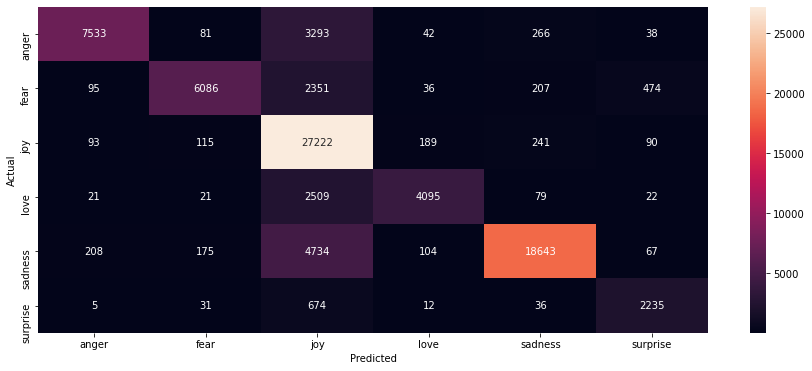

In [41]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

## 3- Under Sampling: ALKNN

### XGboost Approach

In [42]:
from imblearn.under_sampling import AllKNN 

Preprocessing Text Foramt

In [43]:
vectorizer = TfidfVectorizer(max_features=10000)
X_trans = vectorizer.fit_transform(data.text)

Under Sampling 

In [44]:
%%time
al = AllKNN(sampling_strategy='not minority', n_jobs=-1)
X, y = al.fit_resample(X_trans, data.emotions)

Wall time: 1h 20min 46s


In [45]:
print(f"Before under sampling: {X_trans.shape[0]} samples\nAfter under sampling: {X.shape[0]} samples\n\
Diff: {X_trans.shape[0]-X.shape[0]} sample")

Before under sampling: 416123 samples
After under sampling: 206776 samples
Diff: 209347 sample


In [46]:
y.value_counts()

joy         55791
sadness     53507
anger       50982
fear        18391
surprise    14959
love        13146
Name: emotions, dtype: int64

Splitting Data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model Training

In [48]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train, y_train)

Wall time: 21.7 s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Evaluating the Model

In [49]:
preds = clf.predict(X_test)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.79      0.91      0.84     10149
        fear       0.96      0.64      0.77      3766
         joy       0.86      0.81      0.84     11087
        love       0.95      0.54      0.69      2643
     sadness       0.81      0.87      0.84     10740
    surprise       0.80      0.97      0.88      2971

    accuracy                           0.83     41356
   macro avg       0.86      0.79      0.81     41356
weighted avg       0.84      0.83      0.83     41356



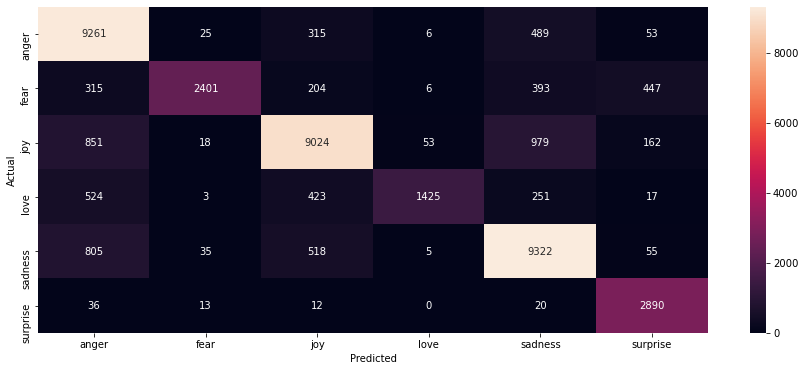

In [50]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

## 1- Over Sampling

there will be a data leakage because the model will train on samples that will see again on the test set

In [51]:
max_class_count = max(data['emotions'].value_counts())

grouped = data.groupby('emotions')['text'].apply(lambda x: x.sample(max_class_count, replace=True))
data_over = grouped.reset_index()
data_over.drop(['level_1'], axis=1, inplace=True)
data_over = data_over.sample(frac=1)
data_over.reset_index(inplace=True, drop=True)
data_over.emotions.value_counts()

surprise    140779
fear        140779
anger       140779
love        140779
joy         140779
sadness     140779
Name: emotions, dtype: int64

### XGboost Approach

Spliting Data

In [52]:
text = data_over['text'].values
y = data_over['emotions'].values

X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.2)

Preprocessing Text Foramt

In [53]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

Training the Model

In [54]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train_trans, y_train)

Wall time: 1min 49s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Evaluating the Model

In [55]:
preds = clf.predict(X_test_trans)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.94      0.86      0.90     28364
        fear       0.91      0.83      0.87     28076
         joy       0.78      0.87      0.82     28187
        love       0.89      0.95      0.92     28389
     sadness       0.96      0.82      0.89     27992
    surprise       0.88      1.00      0.93     27927

    accuracy                           0.89    168935
   macro avg       0.89      0.89      0.89    168935
weighted avg       0.89      0.89      0.89    168935



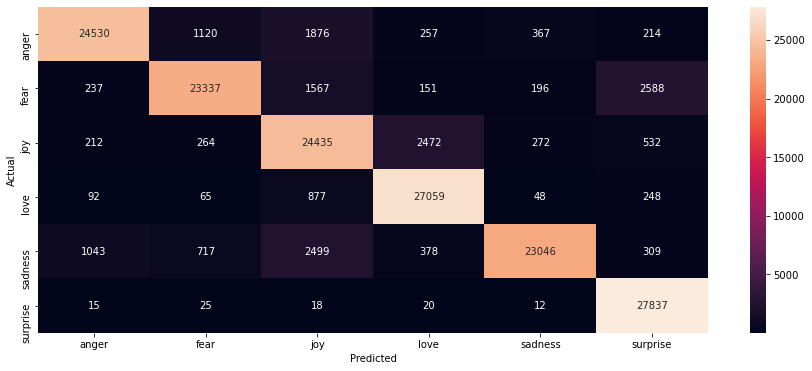

In [56]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

## 2- Over Sampling: SMOTE

In [57]:
from imblearn.over_sampling import SMOTE

### XGboost Approach

Preprocessing Text

In [58]:
vectroizer = TfidfVectorizer(max_features=10000)
X_trans = vectroizer.fit_transform(data.text)

Over Sampling

In [59]:
%%time
SM = SMOTE(n_jobs=-1, sampling_strategy='not majority')
X, y = SM.fit_resample(X_trans, data.emotions)

Wall time: 14min 23s


In [60]:
print(f"Before over sampling: {X_trans.shape[0]} samples\nAfter over sampling: {X.shape[0]} samples\n\
Diff: {X.shape[0] - X_trans.shape[0]}")

Before over sampling: 416123 samples
After over sampling: 844674 samples
Diff: 428551


In [61]:
y.value_counts()

surprise    140779
fear        140779
anger       140779
love        140779
joy         140779
sadness     140779
Name: emotions, dtype: int64

Spliting data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model Training

In [63]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train, y_train)

Wall time: 2min 38s


XGBClassifier(n_jobs=-1, num_class=6, objective='multi:softprob')

Model Evaluating

In [64]:
preds = clf.predict(X_test)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       anger       0.92      0.85      0.89     27968
        fear       0.93      0.82      0.87     27933
         joy       0.76      0.85      0.80     28262
        love       0.90      0.96      0.93     28289
     sadness       0.90      0.80      0.85     28162
    surprise       0.89      0.99      0.94     28321

    accuracy                           0.88    168935
   macro avg       0.88      0.88      0.88    168935
weighted avg       0.88      0.88      0.88    168935



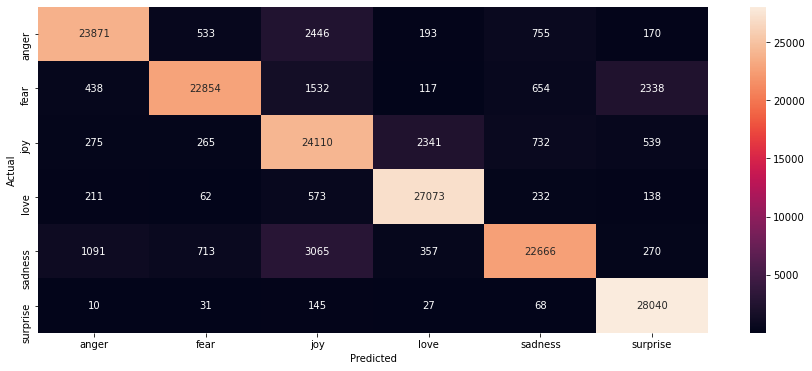

In [65]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);

## Combine: SMOTETomek

<h3>Note:</h3> i won't run this section because it takes a whole lot of time to execute.

In [66]:
from imblearn.combine import SMOTETomek

### XGboost Approach

Preprocessing Text

In [67]:
vectroizer = TfidfVectorizer(max_features=10000)
X_trans = vectroizer.fit_transform(data.text)

Over & under Sampling

In [ ]:
%%time
ST = SMOTETomek(n_jobs=-1, sampling_strategy='not majority')
X, y = ST.fit_resample(X_trans, data.emotions)

In [ ]:
print(f"Before resampling: {X_trans.shape[0]} samples\nAfter resampling: {X.shape[0]} samples\n\
Diff: {X.shape[0] - X_trans.shape[0]} sample")

In [ ]:
y.value_counts()

Spliting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model Training

In [ ]:
%%time
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, n_jobs=-1)
clf.fit(X_train, y_train)

Model Evaluating

In [ ]:
preds = clf.predict(X_test)
# print(f"Acuraccy: {accuracy_score(y_test, preds)}\n")
print(classification_report(y_test, preds))

In [ ]:
show_confusion_matrix(to_indices(y_test), to_indices(preds), classes);